In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
import warnings

In [47]:
warnings.filterwarnings('ignore')  # Ignores all warnings
# Load the data
data_path = '../Data/cirrhosis_clean.csv'
data = pd.read_csv(data_path)
# Display the first few rows of the dataframe to understand its structure
data.head()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,1,-1.432360,0.827904,2.485914,-0.491215,-2.194559,0.684867,-0.123847,0.271931,0.764998,-0.757816,1.470371,1.104369,0,0,0,0,0,0,0
1,2,2.223526,0.608395,-0.476689,-0.305613,1.478942,-0.512297,2.532642,-0.159629,-0.593622,-0.430953,-0.125301,-0.036569,1,0,0,1,0,0,1
2,3,-0.886652,1.898239,-0.410362,-0.876001,-0.095416,1.318660,-0.686329,-0.467356,-1.127366,-1.169029,1.270912,1.104369,0,0,1,1,1,1,2
3,4,-0.072549,0.446938,-0.321927,-0.568172,-2.337683,-0.394928,1.936935,-1.093939,-0.528926,-0.831623,-0.424490,1.104369,0,0,0,1,0,0,2
4,5,-0.447946,-1.127724,0.031817,-0.409731,0.023854,0.532288,-0.613796,-0.166165,-0.852407,-1.327189,0.173887,-0.036569,2,1,0,1,0,0,1


In [48]:
# Separate the features and the target variable
X = data.drop(['ID', 'Status'], axis=1)
y = data['Status']

# Split the data into train+validation (85%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the train+validation into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is approximately 15% of the whole

# Check the size of each set to confirm the split ratio
len(X_train), len(X_val), len(X_test)

(218, 47, 47)

In [49]:
# Define the parameter grid to search
param_grid = {
    'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__solver': ['liblinear', 'sag', 'saga', 'lbfgs']
}

# Define the model for grid search
model_gs = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(random_state=42)))

# Setup the grid search with cross-validation
grid_search = GridSearchCV(model_gs, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit grid search on the train+validation set
grid_search.fit(X_train_val, y_train_val)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 40 candidates, totalling 200 fits


({'onevsrestclassifier__estimator__C': 0.01,
  'onevsrestclassifier__estimator__penalty': 'l2',
  'onevsrestclassifier__estimator__solver': 'liblinear'},
 0.7622641509433963)

In [50]:
# Re-create the model with the best parameters found from grid search
best_model = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(LogisticRegression(
        C=best_params['onevsrestclassifier__estimator__C'],
        penalty=best_params['onevsrestclassifier__estimator__penalty'],
        solver=best_params['onevsrestclassifier__estimator__solver'],
        random_state=42
    ))
)

# Fit the model with the best parameters on the entire training and validation set
best_model.fit(X_train_val, y_train_val)

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)

accuracy_test

0.7872340425531915

In [51]:
# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_test, y_test_pred, average='macro', zero_division=1)
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

print("Precision: {:.2f}".format(precision_test))
print("Recall: {:.2f}".format(recall_test))
print("F1-Score: {:.2f}".format(f1_test))

Precision: 0.86
Recall: 0.58
F1-Score: 0.55


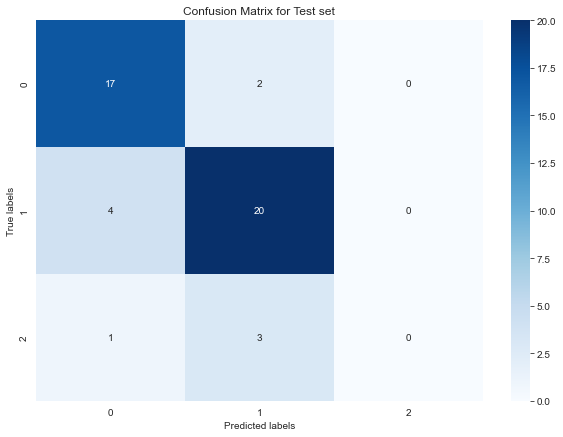

In [52]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test set')
plt.show()

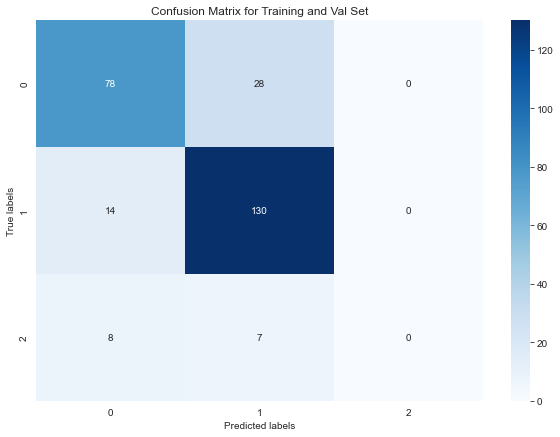

In [53]:
# Predict on the train+validation set to see the performance on the training data
y_train_val_pred = best_model.predict(X_train_val)

# Calculate confusion matrix for the train+validation set
conf_mat_train_val = confusion_matrix(y_train_val, y_train_val_pred)

# Plot the confusion matrix for the train+validation set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_train_val, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Training and Val Set')
plt.show()

In [54]:
# Get the probability predictions for the test set
y_test_proba = best_model.predict_proba(X_test)
# Clip the probability predictions to avoid log(0) issues
y_test_proba_clipped = np.clip(y_test_proba, 1e-15, 1 - 1e-15)

# Calculate the log loss on the test set again after clipping
logloss_test = log_loss(y_test, y_test_proba_clipped)

logloss_test

0.8199275763834937

In [55]:
# Define a new pipeline with PCA and logistic regression for grid search
pca_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic_regression', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

# Define a new parameter grid, considering PCA components and logistic regression parameters
param_grid_pca_lr = {
    'pca__n_components': [1, 2, 3, 4, 5],
    'logistic_regression__estimator__C': [0.01, 0.1, 1, 10, 100],
    'logistic_regression__estimator__penalty': ['l1', 'l2'],
    'logistic_regression__estimator__solver': ['liblinear', 'sag', 'saga', 'lbfgs']
}

# Setup the grid search with cross-validation
grid_search_pca_lr = GridSearchCV(pca_lr_pipeline, param_grid_pca_lr, cv=5, scoring='accuracy', verbose=1)

# Fit grid search on the train+validation set
grid_search_pca_lr.fit(X_train_val, y_train_val)

# Get the best parameters and the best score from the grid search
best_params_pca_lr = grid_search_pca_lr.best_params_
best_score_pca_lr = grid_search_pca_lr.best_score_

best_params_pca_lr, best_score_pca_lr

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


({'logistic_regression__estimator__C': 1,
  'logistic_regression__estimator__penalty': 'l2',
  'logistic_regression__estimator__solver': 'liblinear',
  'pca__n_components': 3},
 0.7773584905660378)

In [56]:
# Re-create the model with the best parameters found from the updated grid search
best_pca_lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_params_pca_lr['pca__n_components'])),
    ('logistic_regression', OneVsRestClassifier(LogisticRegression(
        C=best_params_pca_lr['logistic_regression__estimator__C'],
        penalty=best_params_pca_lr['logistic_regression__estimator__penalty'],
        solver=best_params_pca_lr['logistic_regression__estimator__solver'],
        random_state=42
    )))
])

# Fit the model with the best parameters on the entire training and validation set
best_pca_lr_model.fit(X_train_val, y_train_val)

# Predict on the test set
y_test_pred_best_pca_lr = best_pca_lr_model.predict(X_test)

# Calculate the accuracy on the test set
accuracy_test_best_pca_lr = accuracy_score(y_test, y_test_pred_best_pca_lr)

accuracy_test_best_pca_lr

0.7872340425531915

In [57]:
# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_test, y_test_pred, average='macro', zero_division=1)
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

print("Precision: {:.2f}".format(precision_test))
print("Recall: {:.2f}".format(recall_test))
print("F1-Score: {:.2f}".format(f1_test))

Precision: 0.86
Recall: 0.58
F1-Score: 0.55


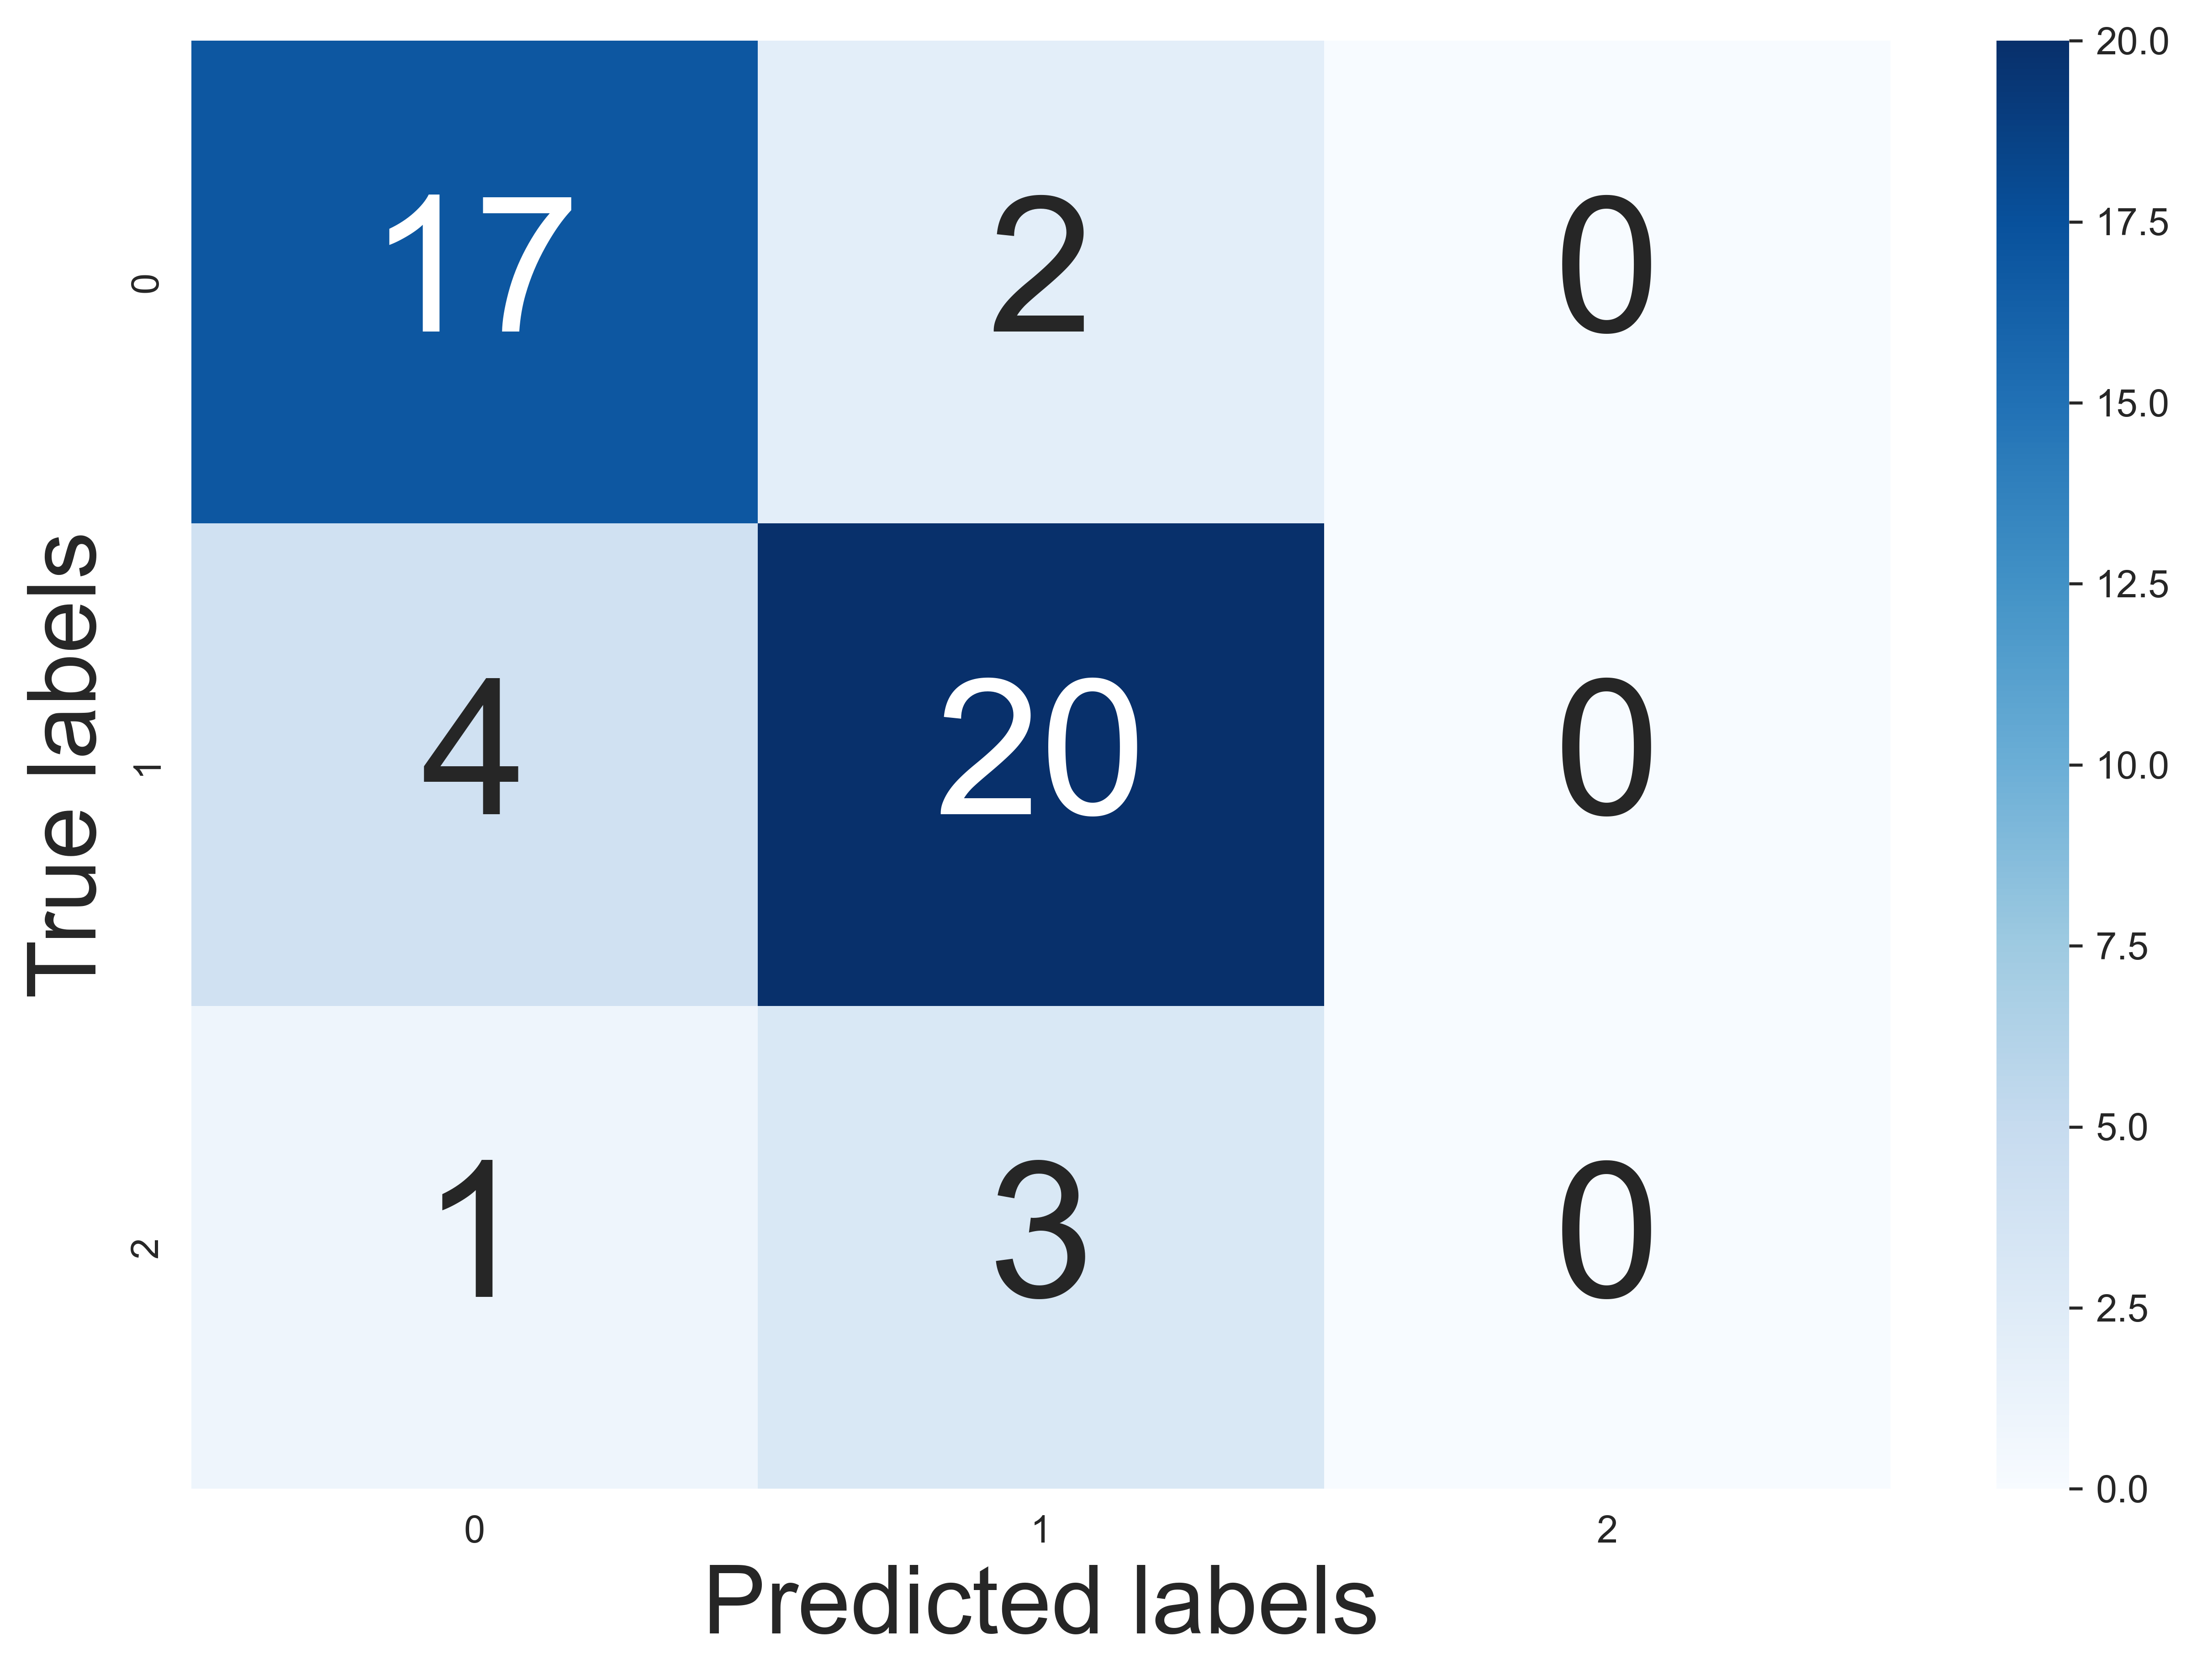

In [58]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred_best_pca_lr)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7), dpi=600)
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2], annot_kws={"size": 50})
plt.xlabel('Predicted labels', fontsize=25)
plt.ylabel('True labels', fontsize=25)
# plt.title('Confusion Matrix for Test Set')
plt.show()

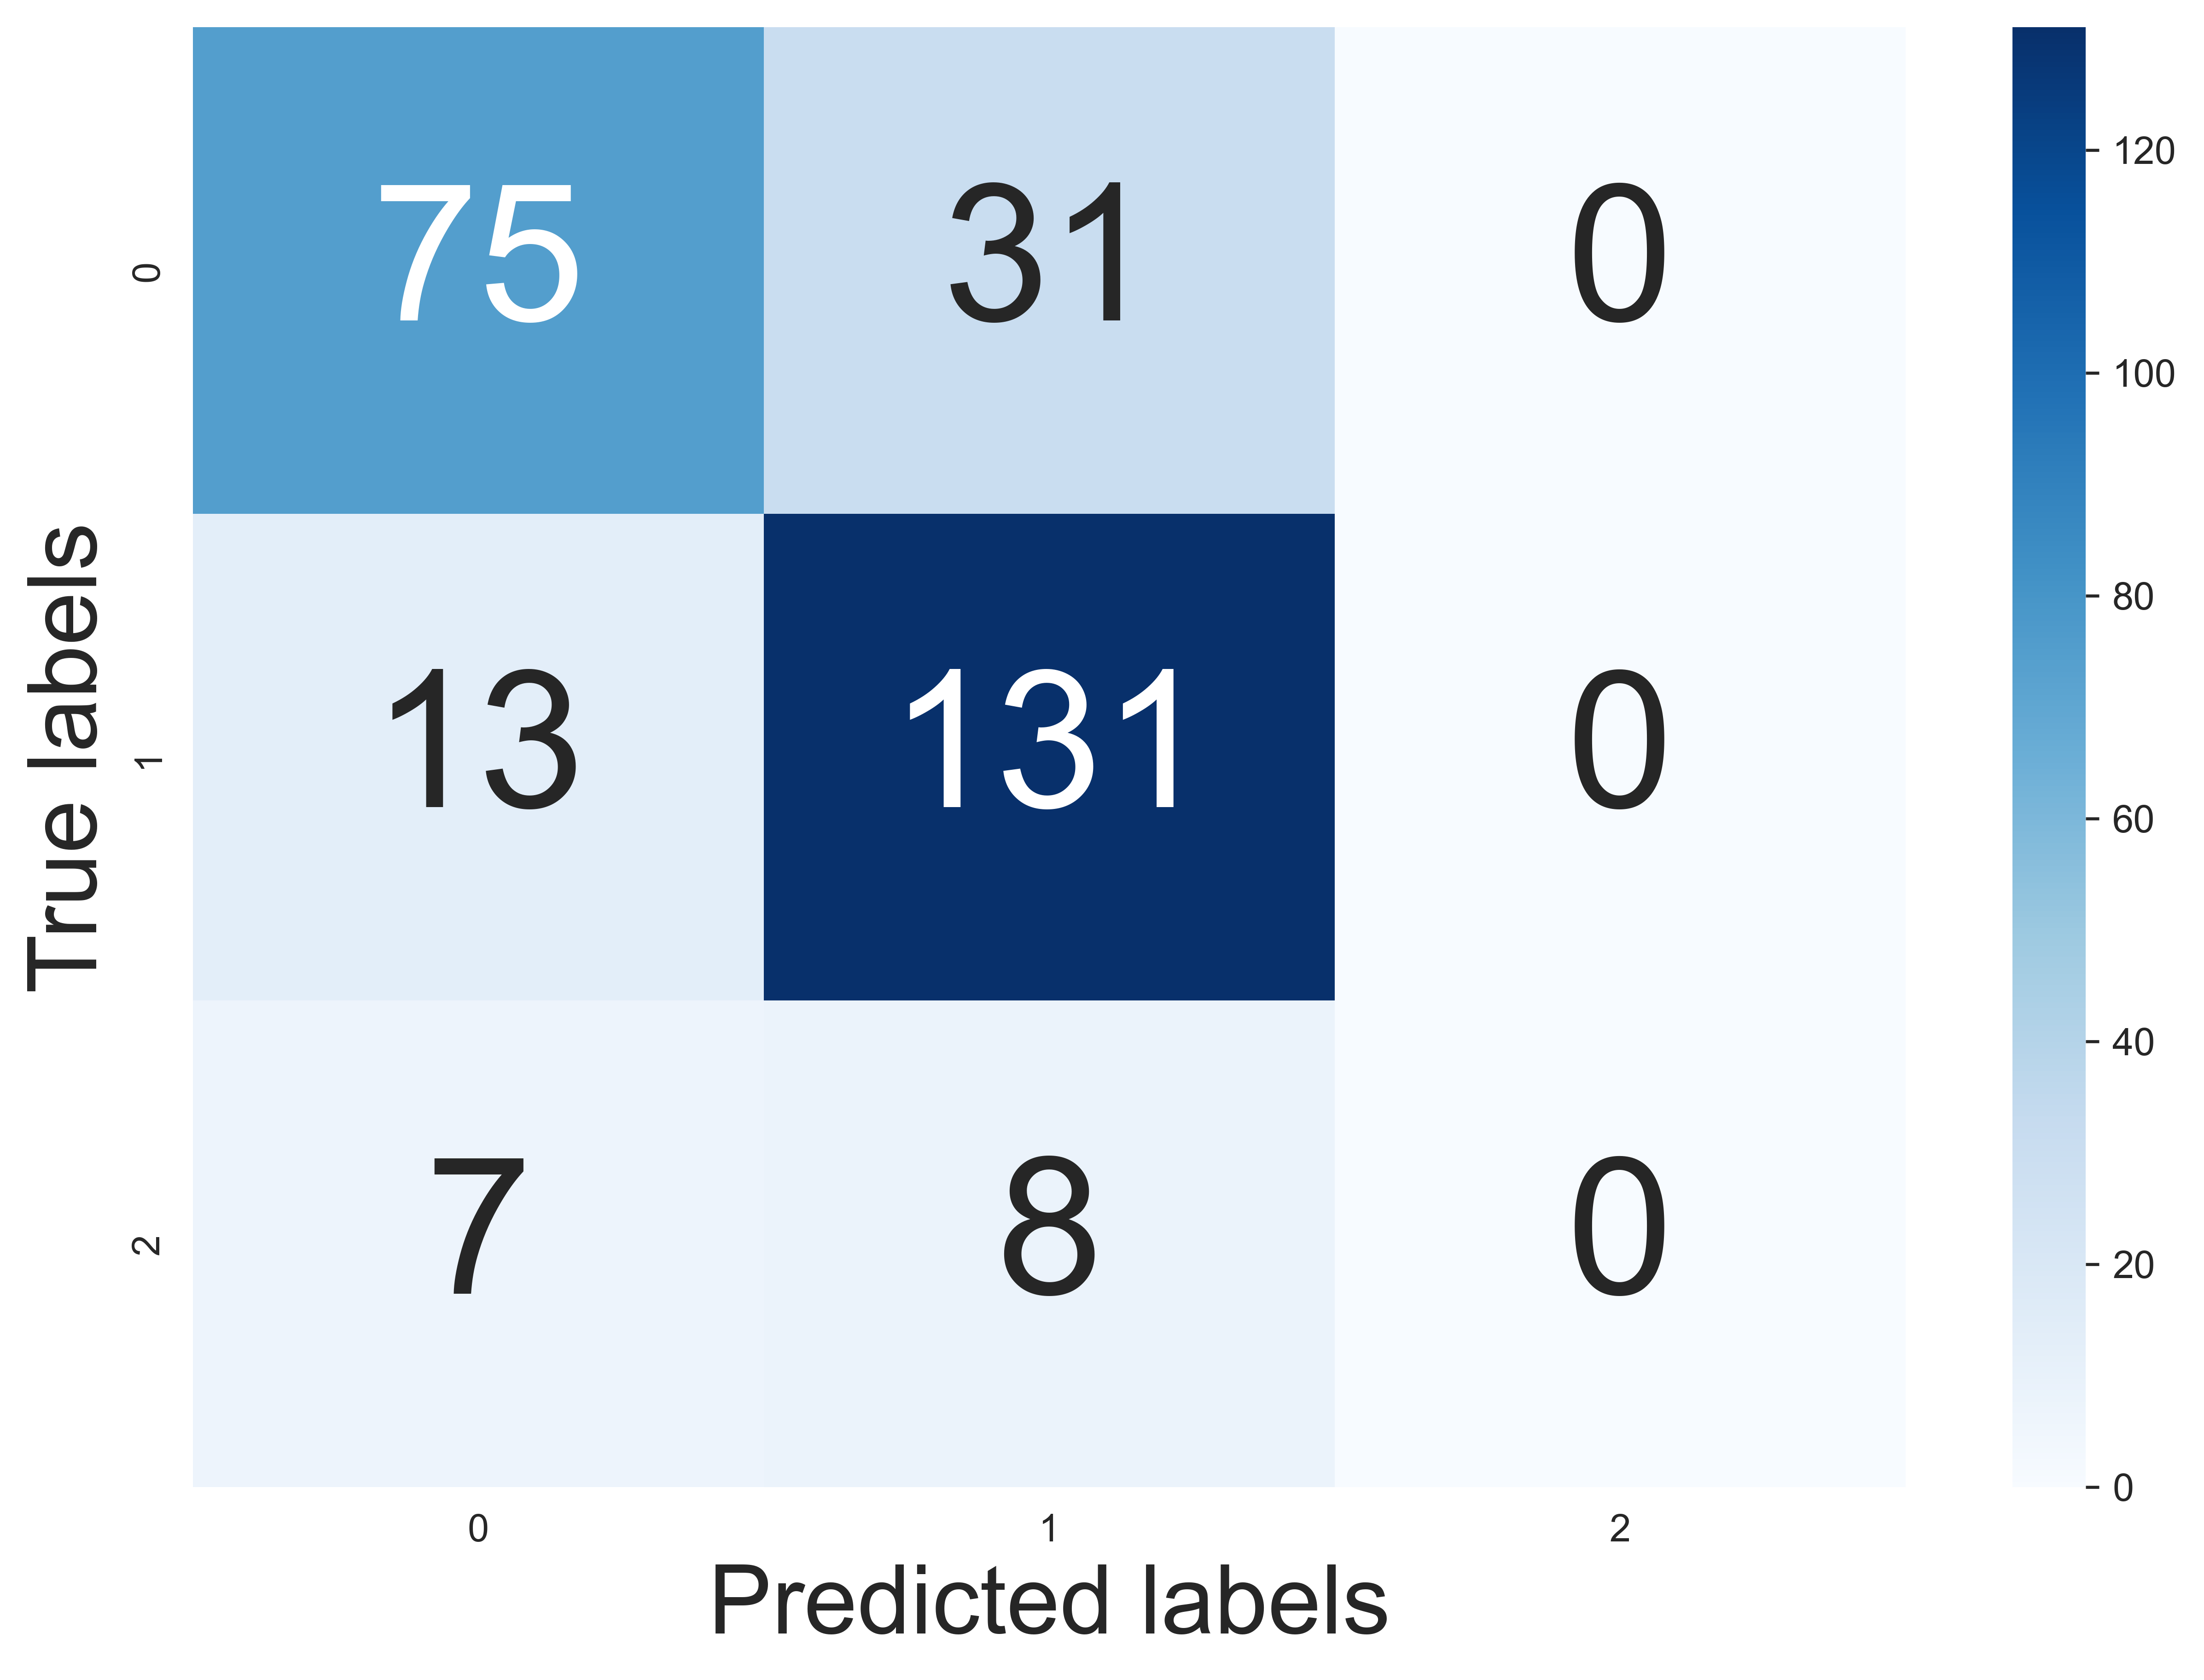

In [59]:
# Predict on the train+validation set to see the performance on the training data
y_train_val_pred = best_pca_lr_model.predict(X_train_val)

# Calculate confusion matrix for the train+validation set
conf_mat_train_val = confusion_matrix(y_train_val, y_train_val_pred)

# Plot the confusion matrix for the train+validation set
plt.figure(figsize=(10, 7), dpi=600)
sns.heatmap(conf_mat_train_val, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2], annot_kws={"size": 50})
plt.xlabel('Predicted labels', fontsize=25)
plt.ylabel('True labels', fontsize=25)
# plt.title('Confusion Matrix for Training and Val Set')
plt.show()

In [60]:
# Get the probability predictions for the test set
y_test_proba = best_pca_lr_model.predict_proba(X_test)
# Clip the probability predictions to avoid log(0) issues
y_test_proba_clipped = np.clip(y_test_proba, 1e-15, 1 - 1e-15)

# Calculate the log loss on the test set again after clipping
logloss_test = log_loss(y_test, y_test_proba_clipped)

logloss_test

0.7041443491510022